## Introduction Example Plots

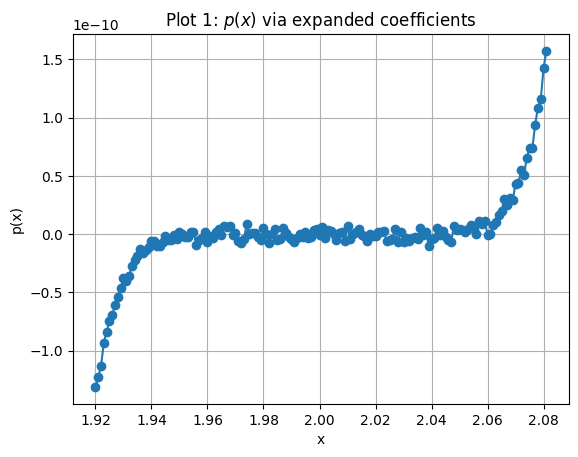

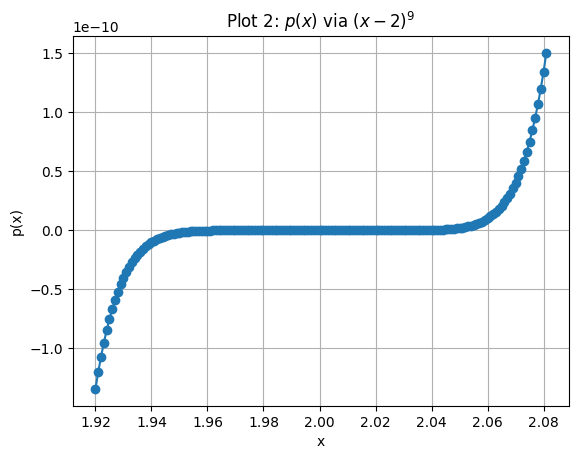

In [54]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(1.920, 2.081, 0.001)
coeffs = [1, -18, 144, -672, 2016, -4032, 5376, -4608, 2304, -512]

y_coeff = np.polyval(coeffs, x)

y_factored = (x - 2.0) ** 9

plt.figure()
plt.plot(x, y_coeff, marker='o', linestyle='-')
plt.title("Plot 1: $p(x)$ via expanded coefficients")
plt.xlabel("x")
plt.ylabel("p(x)")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(x, y_factored, marker='o', linestyle='-')
plt.title("Plot 2: $p(x)$ via $(x-2)^9$")
plt.xlabel("x")
plt.ylabel("p(x)")
plt.grid(True)
plt.show()

## The Hessenberg Reduction Function (a)

In [55]:
import numpy as np
import time
from typing import List, Tuple


def build_householder_unit_vector(
        target_vector: np.ndarray
) -> np.ndarray:
    
    """
    Builds a Householder unit vector

    Args:
        1. target_vector (np.ndarray): Column vector that we want to annihilate (size ≥ 1).

    Returns:
        np.ndarray:
            The normalised Householder vector (‖v‖₂ = 1) with a real first component.

    Raises:
        1. ValueError: If 'target_vector' has zero length.
    """

    if target_vector.size == 0:
        raise ValueError("The target vector is empty; no reflector needed.")

    vector_norm: float = np.linalg.norm(target_vector)

    if vector_norm == 0.0: #nothing to annihilate – return canonical basis vector
        householder_vector: np.ndarray = np.zeros_like(target_vector)
        householder_vector[0] = 1.0
        return householder_vector

    sign_correction: float = (
        1.0 if target_vector[0].real >= 0.0 else -1.0
    )
    copy_of_target_vector: np.ndarray = target_vector.copy()
    copy_of_target_vector[0] += sign_correction * vector_norm
    householder_vector: np.ndarray = (
        copy_of_target_vector / np.linalg.norm(copy_of_target_vector)
    )
    return householder_vector


def to_hessenberg(
        original_matrix: np.ndarray,
) -> Tuple[List[np.ndarray], np.ndarray, np.ndarray]:
    
    """
    Reduce 'original_matrix' to upper Hessenberg form by Householder reflections.

    Args
        1. original_matrix (np.ndarray): Real or complex square matrix of order 'matrix_order'.

    Returns
        Tuple consisting of:

        1. householder_reflectors_list (List[np.ndarray])
        2. hessenberg_matrix (np.ndarray)
        3. accumulated_orthogonal_matrix (np.ndarray)  s.t.
          original_matrix = Q · H · Qᴴ

    Raises
        1. ValueError: If 'original_matrix' is not square.
    """

    working_matrix: np.ndarray = np.asarray(original_matrix).copy()

    if working_matrix.shape[0] != working_matrix.shape[1]:
        raise ValueError("Input matrix must be square.")

    matrix_order: int = working_matrix.shape[0]
    accumulated_orthogonal_matrix: np.ndarray = np.eye(
        matrix_order, dtype=working_matrix.dtype
    )
    householder_reflectors_list: List[np.ndarray] = []

    for column_index in range(matrix_order - 2): #extract the part of column 'column_index' that we want to zero out
        target_column_segment: np.ndarray = working_matrix[
            column_index + 1 :, column_index
        ]

        householder_vector: np.ndarray = build_householder_unit_vector(
            target_column_segment
        )  #build Householder vector for this segment
        householder_reflectors_list.append(householder_vector)

        #expand it to the full matrix dimension
        expanded_householder_vector: np.ndarray = np.zeros(
            matrix_order, dtype=working_matrix.dtype
        )
        expanded_householder_vector[column_index + 1 :] = householder_vector


        working_matrix -= 2.0 * np.outer( 
            expanded_householder_vector,
            expanded_householder_vector.conj().T @ working_matrix,
        ) #apply reflector from BOTH sides
        working_matrix -= 2.0 * np.outer(
            working_matrix @ expanded_householder_vector,
            expanded_householder_vector.conj().T,
        )

        #accumulate Q
        accumulated_orthogonal_matrix -= 2.0 * np.outer(
            accumulated_orthogonal_matrix @ expanded_householder_vector,
            expanded_householder_vector.conj().T,
        )

    hessenberg_matrix: np.ndarray = working_matrix
    return (
        householder_reflectors_list,
        hessenberg_matrix,
        accumulated_orthogonal_matrix,
    )


## Evaluating the Hessenberg Reduction Function


**64×64 general**  
<span style='color:green'>‖A − Q T Qᵀ‖ = 7.51e-14</span>  
‖QᵀQ − I‖ = 7.07e-15

**64×64 symmetric**  
<span style='color:green'>‖A − Q T Qᵀ‖ = 4.83e-14</span>  
‖QᵀQ − I‖ = 7.39e-15

**128×128 general**  
<span style='color:green'>‖A − Q T Qᵀ‖ = 1.84e-13</span>  
‖QᵀQ − I‖ = 1.26e-14

**128×128 symmetric**  
<span style='color:green'>‖A − Q T Qᵀ‖ = 1.14e-13</span>  
‖QᵀQ − I‖ = 1.25e-14

**256×256 general**  
<span style='color:green'>‖A − Q T Qᵀ‖ = 4.70e-13</span>  
‖QᵀQ − I‖ = 2.28e-14

**256×256 symmetric**  
<span style='color:green'>‖A − Q T Qᵀ‖ = 2.78e-13</span>  
‖QᵀQ − I‖ = 2.25e-14

**512×512 general**  
<span style='color:green'>‖A − Q T Qᵀ‖ = 1.16e-12</span>  
‖QᵀQ − I‖ = 4.10e-14

**512×512 symmetric**  
<span style='color:green'>‖A − Q T Qᵀ‖ = 7.10e-13</span>  
‖QᵀQ − I‖ = 4.09e-14

**1024×1024 general**  
<span style='color:green'>‖A − Q T Qᵀ‖ = 3.05e-12</span>  
‖QᵀQ − I‖ = 7.57e-14

**1024×1024 symmetric**  
<span style='color:green'>‖A − Q T Qᵀ‖ = 1.84e-12</span>  
‖QᵀQ − I‖ = 7.64e-14

size,type,reps,avg
64,general,164,5.079e-03
64,symmetric,295,3.121e-03
128,general,74,1.876e-02
128,symmetric,76,1.232e-02
256,general,7,1.597e-01
256,symmetric,16,6.066e-02
512,general,5,1.237e+00
512,symmetric,5,3.771e-01
1024,general,5,2.272e+01
1024,symmetric,5,7.793e+00


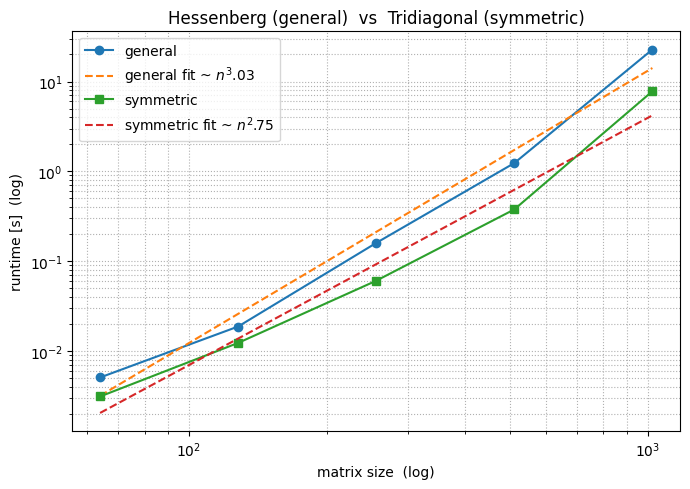

,size,type,reps,avg
0,64,general,164,0.005079
1,64,symmetric,295,0.003121
2,128,general,74,0.018756
3,128,symmetric,76,0.012320
4,256,general,7,0.159749
5,256,symmetric,16,0.060657
6,512,general,5,1.236599
7,512,symmetric,5,0.377066
8,1024,general,5,22.719086
9,1024,symmetric,5,7.793081


In [56]:
import numpy as np
import pandas as pd
import math
import time
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from ast import literal_eval

#RANDOM MATRIX GENERATOR
def generate_random_matrix(n:int, distribution:str="normal",
                           symmetric:bool=False, seed:int|None=None):
    rng = np.random.default_rng(seed)
    if distribution == "normal":
        A = rng.standard_normal((n, n))
    elif distribution == "uniform":
        A = rng.uniform(-1.0, 1.0, size=(n, n))
    else:
        raise ValueError("distribution must be 'normal' or 'uniform'")
    return (A + A.T) / 2.0 if symmetric else A


#REFLECTOR CALCULATOR
def _house_vec(x:np.ndarray) -> np.ndarray:

    """
    Builds a Householder reflector for a given column vector x.
    Args:
        x (np.ndarray): Column vector to be transformed.
    Returns:
        np.ndarray: Normalised Householder vector with a real first component.
    Raises:
        None
    """

    sigma = np.linalg.norm(x)
    if sigma == 0.0:
        e1 = np.zeros_like(x)
        e1[0] = 1.0
        return e1
    sign = 1.0 if x[0].real >= 0.0 else -1.0
    v = x.copy()
    v[0] += sign * sigma
    return v / np.linalg.norm(v)

def hessenberg_reduction(A_in:np.ndarray, symmetric:bool=False, accumulate_q:bool=True):

    """
    Reduces a matrix to upper Hessenberg form using Householder reflections.
    Args:
        A_in (np.ndarray): Input matrix to be reduced.
        symmetric (bool): If True, treat the matrix as symmetric and reduce to tridiagonal form.
        accumulate_q (bool): If True, accumulate the orthogonal matrix Q.
    Returns:
        Tuple[np.ndarray, np.ndarray]: The reduced matrix in Hessenberg form and the orthogonal matrix Q.
    Raises:
        None
    """

    A = A_in.copy()
    n = A.shape[0]
    Q = np.eye(n, dtype=A.dtype)

    if not symmetric:    #GENERAL caSe
        for k in range(n-2):
            v = _house_vec(A[k+1:, k])
            w = np.zeros(n, dtype=A.dtype)
            w[k+1:] = v
            A -= 2.0 * np.outer(w, w.conj().T @ A)
            A -= 2.0 * np.outer(A @ w, w.conj().T)
            if accumulate_q:
                Q -= 2.0 * np.outer(Q @ w, w.conj().T)
        return A, Q

    #SYMMETRIC TRIDIAGONAL CASE
    for k in range(n-2):
        x = A[k+1:, k]
        v = _house_vec(x)
        beta = 2.0

        w = A[k+1:, k+1:] @ v   #trailing submatrix rank-2 update (A ← A − v wᵀ − w vᵀ)
        tau = beta * 0.5 * (v @ w)
        w -= tau * v
        A[k+1:, k+1:] -= beta * np.outer(v, w) + beta * np.outer(w, v)

        new_val = -np.sign(x[0]) * np.linalg.norm(x)   #store the single sub-diagonal element, zero the rest
        A[k+1, k] = new_val
        A[k, k+1] = new_val
        A[k+2:, k] = 0.0
        A[k, k+2:] = 0.0

        if accumulate_q:  #accumulate Q if requested
            Q[:, k+1:] -= beta * np.outer(Q[:, k+1:] @ v, v)

    A = np.triu(A) + np.triu(A, 1).T  #force symmetry
    return A, Q


#VERIFYING PART
def verify_factorisation_once(n:int, dist:str, symmetric:bool, seed:int|None):

    """
    Verifies the factorisation of a random matrix of size n.
    Args:
        n (int): Size of the matrix.
        dist (str): Distribution type ('normal' or 'uniform').
        symmetric (bool): Whether the matrix is symmetric.
        seed (int | None): Random seed for reproducibility.
    Returns:
        None
    Raises:
        None
    """

    A = generate_random_matrix(n, dist, symmetric, seed)
    T, Q = hessenberg_reduction(A, symmetric=symmetric)
    res_fact = np.linalg.norm(A - Q @ T @ Q.T)
    res_orth = np.linalg.norm(Q.T @ Q - np.eye(n))
    colour = "green" if res_fact < 1e-11 else "red"
    typ = "symmetric" if symmetric else "general"
    display(Markdown(
        f"**{n}×{n} {typ}**  \n"
        f"<span style='color:{colour}'>‖A − Q T Qᵀ‖ = {res_fact:.2e}</span>  \n"
        f"‖QᵀQ − I‖ = {res_orth:.2e}"
    ))


def benchmark_hessenberg(size_list, dist:str, mode:str, seed:int|None, reps_small:int=5):

    """
    Benchmark the Hessenberg reduction for various matrix sizes and types.
    Args:
        size_list (list of int): List of matrix sizes to test.
        dist (str): Distribution type ('normal' or 'uniform').
        mode (str): Matrix type ('general', 'symmetric', or 'both').
        seed (int | None): Random seed for reproducibility.
        reps_small (int): Number of repetitions for small matrices.
    Returns:
        pd.DataFrame: DataFrame containing the benchmark results.
    Raises:
        None
    """

    records = []
    for n in size_list:
        for sym in ([False, True] if mode=="both" else [mode=="symmetric"]):
            A = generate_random_matrix(n, dist, sym, seed)

            t0 = time.perf_counter()
            hessenberg_reduction(A, symmetric=sym, accumulate_q=False)
            probe = time.perf_counter() - t0
            reps = reps_small if probe*reps_small >= 1.0 else math.ceil(1.0 / probe)

            times = []
            for _ in range(reps):
                start = time.perf_counter()
                hessenberg_reduction(A, symmetric=sym, accumulate_q=False)
                times.append(time.perf_counter() - start)

            records.append(dict(size=n,
                                type="symmetric" if sym else "general",
                                reps=reps,
                                avg=np.mean(times)))

    df = pd.DataFrame(records)
    display(df.style.format({"avg":"{:.3e}"}).hide(axis="index"))

    plt.figure(figsize=(7,5))
    mark = {"general":"o", "symmetric":"s"}
    for label, sub in df.groupby("type"):
        plt.loglog(sub["size"], sub["avg"], marker=mark[label], ls="-", label=label)
        if len(sub) > 1:
            a,b = np.polyfit(np.log10(sub["size"]), np.log10(sub["avg"]), 1)
            plt.loglog(sub["size"], 10**(b+a*np.log10(sub["size"])),
                       "--", label=f"{label} fit ~ $n^{a:.2f}$")
    plt.xlabel("matrix size  (log)")
    plt.ylabel("runtime [s]  (log)")
    plt.title("Hessenberg (general)  vs  Tridiagonal (symmetric)")
    plt.grid(True, which="both", ls=":")
    plt.legend(); plt.tight_layout(); plt.show()
    return df


#===INTERACTIVE PART=========================================================
try:
    raw = input("\nMatrix sizes (Python list) (e.g): [64,128,256,512,1024]: ")
    sizes = literal_eval(raw) if raw.strip() else [64,128,256,512,1024]
except Exception:
    print("Bad list -> using default.")
    sizes = [64,128,256,512,1024]

dist = input("Distribution ('normal'/'uniform')  [normal]: ").strip().lower() or "normal"
mode_txt = input("Matrix type g=general, s=symmetric, b=both  [g]: ").strip().lower() or "g"
mode = "symmetric" if mode_txt=="s" else "both" if mode_txt=="b" else "general"
seed_txt = input("Random seed (None/int) [None]: ").strip()
seed_val = None if seed_txt.lower() in {"", "none"} else int(seed_txt)

# accuracy on *all* requested sizes
for n in sizes:
    for sym in ([False, True] if mode=="both" else [mode=="symmetric"]):
        verify_factorisation_once(n, dist, sym, seed_val)


benchmark_hessenberg(sizes, dist, mode, seed_val) #timings
